# Simulation Parameter Generation

This notebook explores the production of simulation parameters, e.g.:
* Stations and their capacities
* Stations and the journeys they generate, by time intervals
* Typical durations between pairs of staitons. 

This notebook is not the final place where the resulting sql tables are 'shipped', but is where I interactively explore how to generate them. 

In [1]:
import sqlite3
from os import getcwd, chdir
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import requests
from numpy import isnan
from pathlib import Path

Readme:
This script summaries some bikepoint data and uploads it to the sqlite database.

In [2]:
# work from the project root
if getcwd()[-9:] == 'notebooks':
    chdir("..")

In [32]:
# connect to sqlite database
DBPATH = Path("tfl_project/data/bike_db.db")
db = sqlite3.connect(DBPATH)

## 1. Bikepoint Station Meta-Data
Including **station dock capacity**
This is actually useful for all sorts of EDA and not just simulation

In [5]:
bikepointid_to_commonname = pickle.load( open(Path("tfl_project/data/tfl_lookups/bikepointid_to_commonname.p"), "rb" ) )
bikepointid_to_latlongs = pickle.load( open(Path("tfl_project/data/tfl_lookups/bikepointid_to_latlongs.p"), "rb" ) )

In [6]:
# Manually excluding one timestamp where only three bikepoints were recorded?
station_fill = pd.read_sql_query("""
    SELECT
        timestamp, bikepoint_id, docked, empty, docked + empty AS capacity
    FROM
        station_fill
    WHERE
        timestamp != "2020-06-22 10:00:00"
    """, db, parse_dates=['timestamp'])

In [7]:
bp_capacities = station_fill.pivot_table(index='bikepoint_id', columns='timestamp', values='capacity')

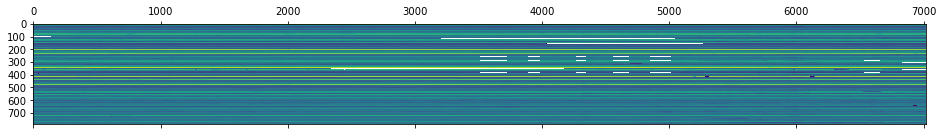

In [8]:
# Inspection
plt.matshow(bp_capacities);

Start to merge station attributes

In [9]:
bp_summaries = pd.merge(
    bp_capacities.max(axis=1).rename('max capacity')
    ,bp_capacities.median(axis=1).rename('median capacity')
    ,right_index=True
    ,left_index=True)

Manually inspect cases where max and median capacity are different

In [10]:
# Inspection
bp_summaries[bp_summaries['max capacity'] != bp_summaries['median capacity']]

,max capacity,median capacity
bikepoint_id,,
14,48.0,46.0
62,24.0,23.0
71,34.0,33.0
74,17.0,16.0
85,40.0,39.0
114,22.0,21.0
190,21.0,20.0
191,36.0,35.0
194,56.0,55.0


So, both max and median give reliable summaries for bikepoint capacity, but in some cases median is slightly lower (e.g. due to docks being out of action?). 

Little bit of a decision on which to use:
* max gives a reflection of the number of physical docks in the system. 
* median gives a 'fairer' reflection of the number that were actually available to TFL for much of the period. 

In [11]:
# Inspection
bp_summaries['max capacity'].max()

64.0

Note, 64 docks should be the point at which we flag an Exception

In [12]:
# Inspection
bp_summaries['max capacity'].min()

10.0

So: Except all stations to have a capacity between 10 and 64

### Merge additional data:

In [13]:
# Merge common name (i.e. english description)
bp_summaries = bp_summaries.merge(
    pd.DataFrame.from_dict(bikepointid_to_commonname, orient='index').rename(columns={0: 'common_name'})
    ,how='outer'
    ,left_index=True
    ,right_index=True
)

In [14]:
# Merge geographic coordiantes
bp_summaries = bp_summaries.merge(
    pd.DataFrame.from_dict(bikepointid_to_latlongs, orient='index').rename(columns={0: 'latitude', 1:'longitude'})
    ,how='outer'
    ,left_index=True
    ,right_index=True
)

In [15]:
# Inspection
bp_summaries.head()

,max capacity,median capacity,common_name,latitude,longitude
1,19.0,19.0,"River Street , Clerkenwell",51.529163,-0.109970
2,37.0,37.0,"Phillimore Gardens, Kensington",51.499606,-0.197574
3,32.0,32.0,"Christopher Street, Liverpool Street",51.521283,-0.084605
4,23.0,23.0,"St. Chad's Street, King's Cross",51.530059,-0.120973
5,27.0,27.0,"Sedding Street, Sloane Square",51.493130,-0.156876


Inspect stations with missing data

In [16]:
# Inspection
bp_summaries[bp_summaries.isnull().any(axis=1)]

,max capacity,median capacity,common_name,latitude,longitude
65,17.0,17.0,NaN,NaN,NaN
95,15.0,15.0,NaN,NaN,NaN
320,26.0,26.0,NaN,NaN,NaN
355,21.0,20.0,NaN,NaN,NaN
378,42.0,42.0,NaN,NaN,NaN
391,NaN,NaN,"Clifford Street, Mayfair",51.510662,-0.142345
398,30.0,30.0,NaN,NaN,NaN
408,40.0,40.0,NaN,NaN,NaN
794,28.0,27.0,NaN,NaN,NaN
808,33.0,33.0,NaN,NaN,NaN


Where possible, I will **plug missing data with a more recent call from the API**. 

I'll start by re-using some functions from my existing module which is used for logging station data

In [18]:
from tfl_project.tfl_api_logger import bikeStationStatus

In [20]:
bike_json = bikeStationStatus.request_station_status(
    credentials=bikeStationStatus.read_api_credentials(Path('tfl_project/tfl_api_logger/apiCredentials.txt'))
)

Impute missing values with API data

In [21]:
# for convenience I take a copy of the subset of problem rows
# The actual fix edits the original bp_summaries dataframe
to_fix = bp_summaries[bp_summaries.isnull().any(axis=1)]

In [22]:
# Inspection
to_fix

,max capacity,median capacity,common_name,latitude,longitude
65,17.0,17.0,NaN,NaN,NaN
95,15.0,15.0,NaN,NaN,NaN
320,26.0,26.0,NaN,NaN,NaN
355,21.0,20.0,NaN,NaN,NaN
378,42.0,42.0,NaN,NaN,NaN
391,NaN,NaN,"Clifford Street, Mayfair",51.510662,-0.142345
398,30.0,30.0,NaN,NaN,NaN
408,40.0,40.0,NaN,NaN,NaN
794,28.0,27.0,NaN,NaN,NaN
808,33.0,33.0,NaN,NaN,NaN


In [23]:
ids_to_fix = ['BikePoints_' + str(id_) for id_ in to_fix.index]

In [24]:
for station in bike_json:
    if station['id'] in ids_to_fix:
        found_id = int(station['id'][11:])
        fixing_row = to_fix.loc[found_id]
        if not isinstance(fixing_row['common_name'], str):
            print(f"Adding common_name to bikepoint {found_id}")
            bp_summaries.loc[found_id, 'common_name'] = station['commonName']
        if isnan(fixing_row['latitude']):
            print(f"Adding co-ordinates to bikepoint {found_id}")
            bp_summaries.loc[found_id,'latitude'] = station['lat']
            bp_summaries.loc[found_id,'longitude'] = station['lon']
        if isnan(fixing_row['median capacity']):
            print(f"Adding capacities to {found_id}")
            bp_summaries.loc[found_id,'median capacity'] = [p['value'] for p in station['additionalProperties'] if p['key'] == 'NbDocks'][0]
            bp_summaries.loc[found_id,'max capacity'] = [p['value'] for p in station['additionalProperties'] if p['key'] == 'NbDocks'][0]

Adding common_name to bikepoint 320
Adding co-ordinates to bikepoint 320
Adding common_name to bikepoint 378
Adding co-ordinates to bikepoint 378
Adding common_name to bikepoint 398
Adding co-ordinates to bikepoint 398
Adding common_name to bikepoint 95
Adding co-ordinates to bikepoint 95
Adding capacities to 391


In [25]:
# Inspection
bp_summaries[bp_summaries.isnull().any(axis=1)]

,max capacity,median capacity,common_name,latitude,longitude
65,17,17,NaN,NaN,NaN
355,21,20,NaN,NaN,NaN
408,40,40,NaN,NaN,NaN
794,28,27,NaN,NaN,NaN
808,33,33,NaN,NaN,NaN


We are now left with 5 missing stations. Manual inspection suggests these have all been closed / inactive in recent months. 
Question is: how to get their location...? 

Options:
* Impute a centroid co-ordinate
* Infer a co-ordiate based on journey durations from other stations (smart but a lot of effort for 5 stations). 
* Replace these stations with the null -1 station ID
* Our distnace metric could be based on average duration rather than euclidean distance. This might actually be a more sensible approach. 

In [26]:
bp_summaries.index.name = 'bikepoint_id'

Upload to SQLite database

In [27]:
# This should no-longer do run in a notebook: there's a script for it
### bp_summaries.to_sql('station_metadata', db, if_exists='fail', index=True)

# 2. Station Journey Demand by time

2.1 The Poisson rate (average journeys) generated at a station, irrespective of desination, per time interval.

In [29]:
def weekday_journey_rates(minute_interval=20, min_year=2015, additional_wheres=''):
    return pd.read_sql_query(f"""
        WITH subset AS (
            SELECT *
            FROM journeys
            WHERE
                year >= {min_year}
                AND weekday_ind = 1
                {additional_wheres}
        )

        SELECT
            i."StartStation Id"
            ,i.interval
            ,CAST(i.interval_journeys AS REAL) / d.days_in_action AS avg_journeys_p_interval
            ,CAST(i.interval_journeys AS REAL) / d.days_in_action / {minute_interval} AS avg_journeys_p_minute
        FROM
            (
                SELECT
                    "StartStation Id"
                    ,(minute_of_day / {minute_interval}) * {minute_interval} AS interval
                    ,COUNT(*) AS interval_journeys
                FROM 
                    subset
                GROUP BY 1,2
            )AS i
            INNER JOIN (
                SELECT
                    "StartStation Id"
                    ,COUNT(DISTINCT DATE("Start Date")) AS days_in_action
                FROM 
                    subset
                GROUP BY 1
            ) AS d
                ON i."StartStation Id" = d."StartStation Id"
        ;
        """, db)

In [30]:
def plot_test(df):
    test = df.pivot_table(index='interval', columns='StartStation Id', values='avg_journeys_p_interval')
    ax = test.plot(figsize=(15,10));
    return ax.get_legend().remove();

In [33]:
test = weekday_journey_rates(20, 2015
                            ,additional_wheres="""AND "Start Date" <= '2020-03-15'""")

In [34]:
test.head()

,StartStation Id,interval,avg_journeys_p_interval,avg_journeys_p_minute
0,-1,0,0.609177,0.030459
1,-1,20,0.418513,0.020926
2,-1,40,0.329114,0.016456
3,-1,60,0.306962,0.015348
4,-1,80,0.243671,0.012184


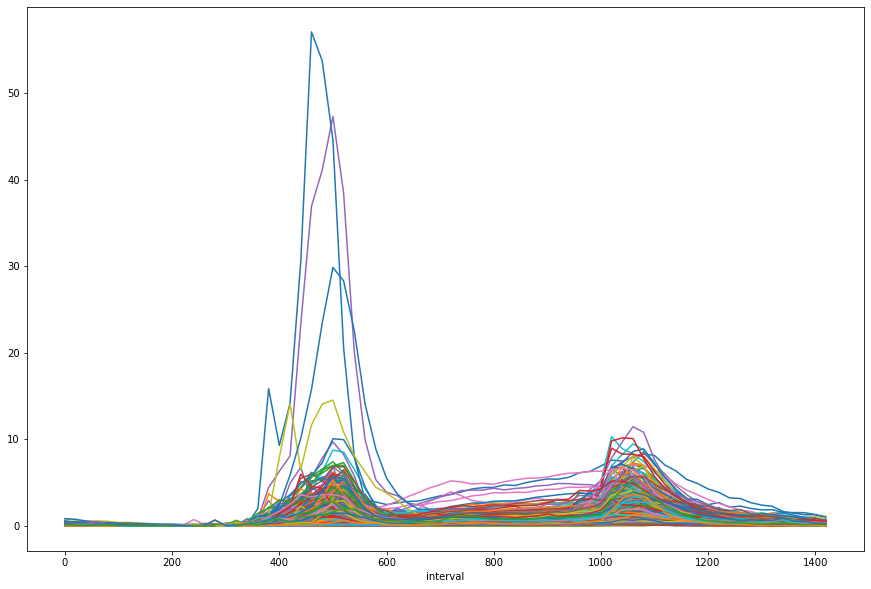

In [35]:
plot_test(test)

It should be very easy to extract parameters for the simulation from this query. Consider writing it to a table since it will be used many times. 

# 3. Multinomial distribution of Destinations by Time

Similar exercise to before, except that now each (station, interval) pair has a vector of destinations.

I experimented with calculating the normalised probabilities and applying laplace smoothing as part of this SQL query, which reduces the load on the simulation.

But I am electing not to apply any laplace smoothing as part of the sql query since it results in an explosive cartesian product and wasteful storage of (sparse) data. Instead: the simulation can apply the laplace smoothing after fetching the (dense) data if it needs it. 

In [36]:
def weekday_destinations(minute_interval=20, min_year=2015, additional_wheres=''):
    """
    Fetches journey counts per any (start_station, end_station, interval) combination for which journeys were
    observed. 
    
    Note: Dense data. No rows will be present for a given (s, e, i) combination where there were no journeys. 
    This needs to be considered if applying laplace smoothing. 
    """
    return pd.read_sql_query(f"""
        SELECT
            "StartStation Id"
            ,"EndStation Id"
            ,interval
            ,journeys
            ,CAST(journeys AS REAL) / SUM(journeys) OVER(PARTITION BY "StartStation Id", interval) AS normalised_journey_rate
        FROM (
            SELECT
                "StartStation Id"
                ,"EndStation Id"
                ,(minute_of_day / {minute_interval}) * {minute_interval} AS interval
                ,COUNT(*) AS journeys
            FROM
                journeys
            WHERE
                year >= {min_year}
                AND weekday_ind = 1
                {additional_wheres}
            GROUP BY
                1,2,3
            ) AS sub

        ;
        """, db)

In [37]:
test2 = weekday_destinations(20, 2015
                            ,additional_wheres="""AND "Start Date" <= '2020-03-15'""")

In [38]:
test2

,StartStation Id,EndStation Id,interval,journeys,normalised_journey_rate
0,-1,NaN,0,9,0.011688
1,-1,-1.0,0,68,0.088312
2,-1,1.0,0,1,0.001299
3,-1,2.0,0,1,0.001299
4,-1,6.0,0,2,0.002597
...,...,...,...,...,...
7948666,839,552.0,1420,1,0.016129
7948667,839,809.0,1420,1,0.016129
7948668,839,815.0,1420,3,0.048387
7948669,839,819.0,1420,4,0.064516


In [39]:
test2[(test2.interval == 240) & (test2.journeys > 50)].head()

,StartStation Id,EndStation Id,interval,journeys,normalised_journey_rate
752615,60,-1.0,240,173,0.497126
752618,60,111.0,240,158,0.454023
1217343,98,393.0,240,945,0.925563
1783689,142,266.0,240,165,0.785714
2648540,216,277.0,240,143,0.772973


# 4. Destination Durations

For each pair of stations, what is the distribution of journey durations

In [40]:
test3 = pd.read_sql_query(f"""
        SELECT
            "StartStation Id"
            ,"EndStation Id"
            ,Duration
        FROM
            journeys
        WHERE
            "StartStation Id" = 154
            AND year >= 2015
            AND weekday_ind = 1
            -- FOR TESTING
            AND "EndStation Id" % 30 = 0
        """, db)

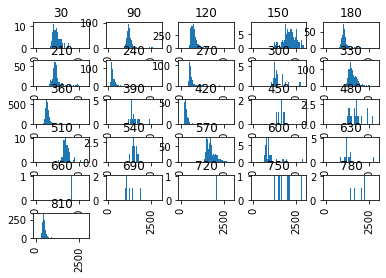

In [41]:
test3.drop("StartStation Id",axis=1).hist(column="Duration", bins=[i*60 for i in range(50)], by="EndStation Id");

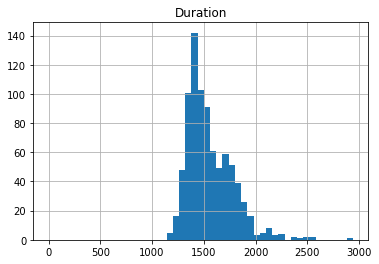

In [42]:
test3[test3["EndStation Id"]== 330].hist(column="Duration" , bins=[i*60 for i in range(50)]);

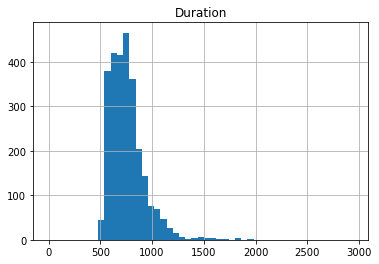

In [43]:
test3[test3["EndStation Id"]== 120].hist(column="Duration" , bins=[i*60 for i in range(50)]);

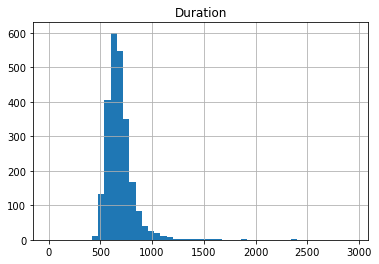

In [44]:
test3[test3["EndStation Id"]== 360].hist(column="Duration" , bins=[i*60 for i in range(50)]);

In [45]:
test3[test3["EndStation Id"]== 360]['Duration'].mean()

683.7158154859967

### What distribution? 

O Mahoney used a Poisson distribution to model journey durations, but I find this to be a dubious assumption: inspecting some examples suggest that it gives an overly narrow probability distribution

Some alterantives I'd like to explore are:
* Skewed-Norm 
* Right-tailed Gumbel distribution

In [46]:
example360 = test3[test3["EndStation Id"]== 360]['Duration'].copy()

In [47]:
hisbins = [i*60 for i in range(30)]

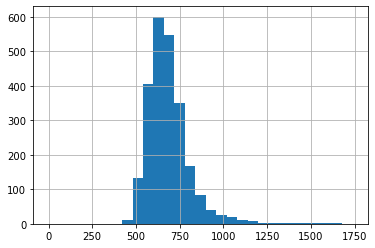

In [48]:
example360.hist(bins=hisbins);

In [49]:
from scipy import stats
from numpy import linspace

In [50]:
import numpy.random

In [57]:
def compare_sknorm_gumbel(df, endstation, poisson=True):
    data = df[df["EndStation Id"]== endstation]['Duration']
    hisbins = [i for i in range(30)]
    sn = stats.skewnorm(*stats.skewnorm.fit(data))
    gr = stats.gumbel_r(*stats.gumbel_r.fit(data))
    x = linspace(0, 5, 100)
    ax = plt.hist(data, density = True, bins = hisbins)
    
    plt.plot(x, sn.pdf(x), label = 'SkewNorm Distribution')
    plt.plot(x, gr.pdf(x), label = 'Right Gumbel Distribution')
    # poisson for comparison:
    if poisson:
        lam = data.mean()
        plt.hist(numpy.random.poisson(lam, 2000), bins=hisbins, density=True, alpha=0.2, label='Poisson Distribution')
    plt.hist(gr.rvs(2000), density=True, alpha=0.5, label='Gumbel', bins=hisbins)
    plt.legend()

C:\Users\Josh\Anaconda2\envs\tflProject\lib\site-packages\scipy\stats\_distn_infrastructure.py:1625: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


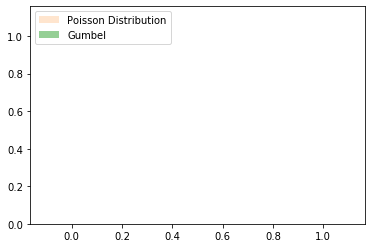

In [58]:
compare_sknorm_gumbel(test3, 360);

C:\Users\Josh\Anaconda2\envs\tflProject\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


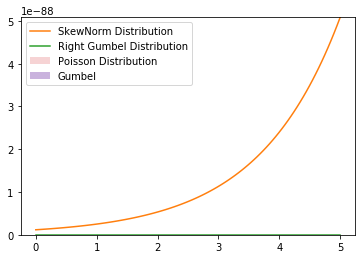

In [53]:
compare_sknorm_gumbel(test3, 120);

C:\Users\Josh\Anaconda2\envs\tflProject\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


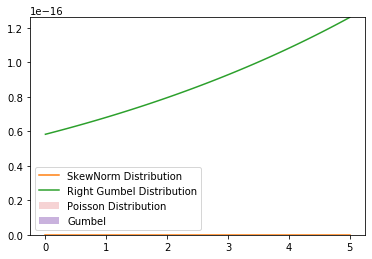

In [54]:
compare_sknorm_gumbel(test3, 600);

C:\Users\Josh\Anaconda2\envs\tflProject\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


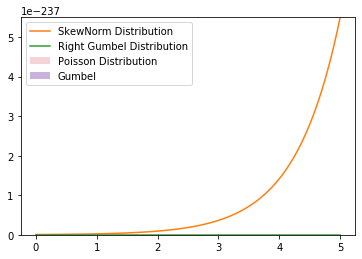

In [55]:
compare_sknorm_gumbel(test3, 180);

C:\Users\Josh\Anaconda2\envs\tflProject\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


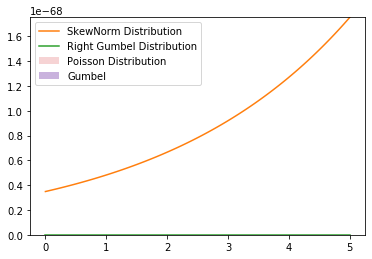

In [56]:
compare_sknorm_gumbel(test3, 30);